In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

In [ ]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
for i, example in enumerate(dataset['train']):
  image,label = example
  save_dir = 'tf_flowers/train/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)

  filepath = save_dir + "/" + "{}_{}.jpg".format(class_names[label], i)
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2,
                             rotation_range=10, width_shift_range = 0.1, height_shift_range=0.1,
                             shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

train_generator = datagen.flow_from_directory('tf_flowers/train', target_size=(224,224), batch_size=4,
                                              class_mode="categorical", subset='training')

validation_generator = datagen.flow_from_directory('tf_flowers/train', target_size=(224,224), batch_size=4,
                                              class_mode="categorical", subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [ ]:
history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
735/735 [==============================] - 87s 101ms/step - loss: 1.3163 - accuracy: 0.4379 - val_loss: 1.2114 - val_accuracy: 0.5253
Epoch 2/5
735/735 [==============================] - 72s 98ms/step - loss: 1.1073 - accuracy: 0.5621 - val_loss: 1.0266 - val_accuracy: 0.6197
Epoch 3/5
735/735 [==============================] - 72s 98ms/step - loss: 0.9960 - accuracy: 0.6084 - val_loss: 0.9180 - val_accuracy: 0.6416
Epoch 4/5
735/735 [==============================] - 73s 100ms/step - loss: 0.9080 - accuracy: 0.6553 - val_loss: 0.8659 - val_accuracy: 0.6689
Epoch 5/5
735/735 [==============================] - 73s 99ms/step - loss: 0.8512 - accuracy: 0.6785 - val_loss: 0.9394 - val_accuracy: 0.6648


In [ ]:
from tensorflow.keras.applications import VGG16
model_vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layer in model_vgg16.layers:
  layer.trainable=False

model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()
model.add(model_vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
735/735 [==============================] - 63s 83ms/step - loss: 1.5939 - accuracy: 0.5260 - val_loss: 0.8095 - val_accuracy: 0.7182
Epoch 2/5
735/735 [==============================] - 58s 79ms/step - loss: 0.9392 - accuracy: 0.6393 - val_loss: 0.8347 - val_accuracy: 0.6758
Epoch 3/5
735/735 [==============================] - 60s 81ms/step - loss: 0.8500 - accuracy: 0.6679 - val_loss: 0.6824 - val_accuracy: 0.7360
Epoch 4/5
735/735 [==============================] - 58s 79ms/step - loss: 0.7996 - accuracy: 0.7047 - val_loss: 0.6205 - val_accuracy: 0.7852
Epoch 5/5
735/735 [==============================] - 59s 80ms/step - loss: 0.7815 - accuracy: 0.6887 - val_loss: 0.6478 - val_accuracy: 0.7647


In [ ]:
model.save('flowers_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
flowers = tf.keras.models.load_model('flowers_classifier.h5')

In [ ]:
flowers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27562821 (105.14 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [42]:
import cv2
from PIL import Image

In [36]:
def predict(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (224,224))
  img = np.reshape(img, [1,224,224,3])
  img = img/255

  preds = flowers.predict(img)

  max_idx = np.argmax(preds)
  class_indices = {v:k for k,v in train_generator.class_indices.items()}
  print(class_indices[max_idx])

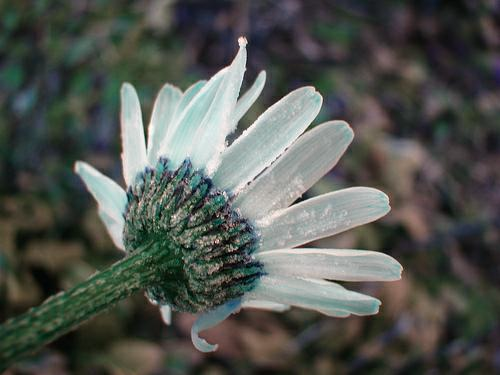

In [44]:
img = cv2.imread('/content/tf_flowers/train/daisy/daisy_747.jpg')
daisy=Image.fromarray(img)
daisy

In [45]:
predict('/content/tf_flowers/train/daisy/daisy_747.jpg')

1/1 [==============================] - 0s 19ms/step
daisy


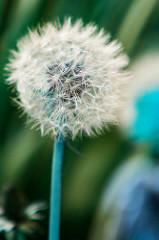

In [52]:
img1 = cv2.imread('/content/tf_flowers/train/dandelion/dandelion_970.jpg')
dandelion=array_to_img(img1)
dandelion

In [53]:
predict('/content/tf_flowers/train/dandelion/dandelion_970.jpg')

1/1 [==============================] - 0s 19ms/step
dandelion


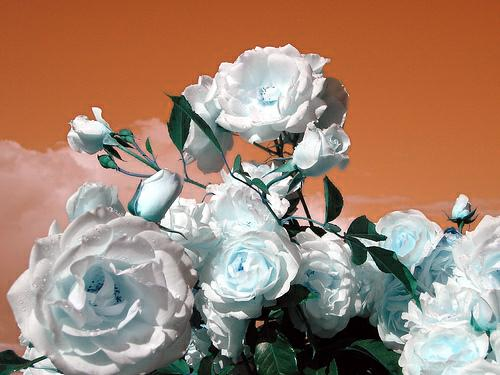

In [55]:
img2 = cv2.imread('/content/tf_flowers/train/roses/roses_1019.jpg')
roses=array_to_img(img2)
roses

In [56]:
predict('/content/tf_flowers/train/roses/roses_1019.jpg')

1/1 [==============================] - 0s 23ms/step
roses


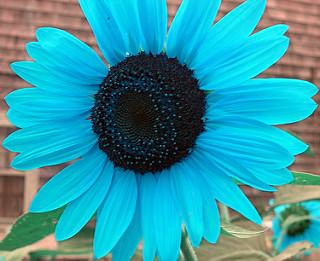

In [58]:
img3 = cv2.imread('/content/tf_flowers/train/sunflowers/sunflowers_1022.jpg')
sunflower=array_to_img(img3)
sunflower

In [59]:
predict('/content/tf_flowers/train/sunflowers/sunflowers_1022.jpg')

1/1 [==============================] - 0s 21ms/step
sunflowers


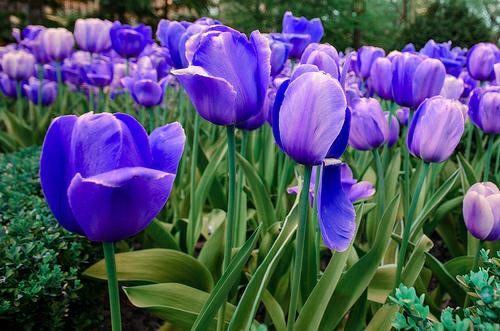

In [60]:
img4 = cv2.imread('/content/tf_flowers/train/tulips/tulips_1239.jpg')
tulip=array_to_img(img4)
tulip

In [61]:
predict('/content/tf_flowers/train/tulips/tulips_1239.jpg')

1/1 [==============================] - 0s 19ms/step
tulips
